In [1]:
import os, pickle
import pandas as pd
import numpy as np
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

/data/anaconda3/envs/hanliu-tutorial/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# train_ds = ImageFolder('../data/weevil_vespula/train')
# valid_ds = ImageFolder('../data/weevil_vespula/valid')
# test_ds = ImageFolder('../data/weevil_vespula/test')
# y_train = np.array([y for _, y in train_ds])
# y_valid = np.array([y for _, y in valid_ds])
# y_test = np.array([y for _, y in test_ds])
# ytvs = y_train, y_valid, y_test

In [5]:
df = pd.read_csv('../data/weevil_vespula/vw2d.relabelled.csv', index_col=0)
selected_features = ["bodyheadszratio", "bodyheadcolordiff"]
x, y = df[selected_features].values, df['pseudo_label'].values

In [6]:
p2i_train = pickle.load(open('../data/weevil_vespula/p2i.pkl', 'rb'))
p2i_valid = pickle.load(open('../data/weevil_vespula/p2i_valid.pkl', 'rb'))
p2i_test = pickle.load(open('../data/weevil_vespula/p2i_test.pkl', 'rb'))
i2p_train = {v:int(k) for k, v in p2i_train.items()}
i2p_valid = {v:int(k) for k, v in p2i_valid.items()}
i2p_test = {v:int(k) for k, v in p2i_test.items()}

In [67]:
x_train, y_train = x[sorted(i2p_train.values())], y[sorted(i2p_train.values())]
x_valid, y_valid = x[sorted(i2p_valid.values())], y[sorted(i2p_valid.values())]
x_test, y_test = x[sorted(i2p_test.values())], y[sorted(i2p_test.values())]

In [68]:
def trans(x, w):
    return np.diag(w).dot(x.T).T

def plot(x, xt, figsize=(13, 6), xlim=[-0.2, 1], ylim=[-0.2, 1]):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    ax[0].set_title('feature'); ax[1].set_title('human')
    ax[0].scatter(x[:,0][y==0], x[:,1][y==0])
    ax[0].scatter(x[:,0][y==1], x[:,1][y==1])
    ax[1].scatter(xt[:,0][y==0], xt[:,1][y==0])
    ax[1].scatter(xt[:,0][y==1], xt[:,1][y==1])
    ax[0].set_xlim(xlim); ax[1].set_xlim(xlim)
    ax[0].set_ylim(ylim); ax[1].set_ylim(ylim)
    return fig, ax

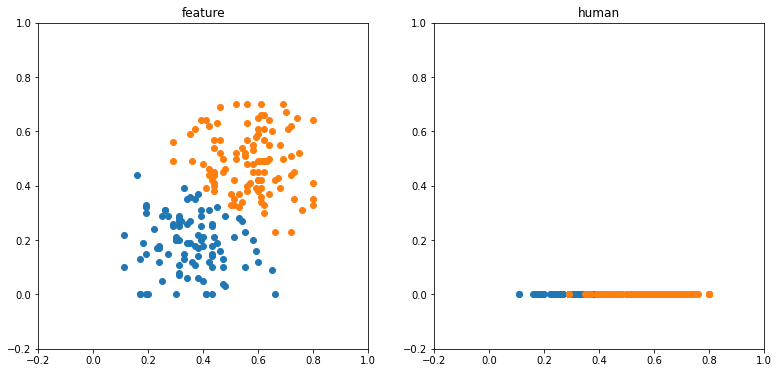

In [89]:
w = [1, 0]
xt = trans(x, w)
_ = plot(x, xt)

In [71]:
from sklearn.metrics.pairwise import euclidean_distances as euc_dist
def ord_dist(a, b, order=2):
    order = np.array(order) if type(order) != int else order
    root = 2 if type(order) != int and len(order) > 1 else order
    diff = a[:,np.newaxis].repeat(len(b),1) - b
    return (np.abs(diff)**order).sum(-1)**(1/root)

In [167]:
w = [5, 0]
xt = trans(x, w)
# _ = plot(x, xt)
h_train = trans(x_train, w)
h_valid = trans(x_valid, w)
h_test = trans(x_test, w)
h_dst = euc_dist(h_test, h_train)
nino = get_nn_mat(h_dst, y_test, y_train)
import embed_evals as evals
evals.get_knn_score(h_train, y_train, h_test, y_test)


0.725

In [157]:
import embed_evals as evals
evals.get_knn_score(h_train, y_train, h_test, y_test)


0.725

In [137]:
def get_nn_mat(dist, y_test, y_train):
    mask_train = np.tile(y_train, (len(y_test), 1))
    apply_mask = lambda x, m: x + (-(m - 1) * x.max())
    nn_mat = np.arange(len(y_test)).reshape(-1, 1)
    for label in np.sort(np.unique(y_train)):
        mask_in = label == mask_train
        in1nn = np.argmin(apply_mask(dist, mask_in), 1)
        nn_mat = np.hstack([nn_mat, in1nn.reshape(-1, 1)])
    return nn_mat

def eval_nn_mat(dist, nn_mat, y_test, y_train):
    dst = dist.take(nn_mat[:,0], 0)
    dnn = np.vstack([np.take_along_axis(
        dst, nn_mat[:,1+c].reshape(-1,1), 1).ravel() for c in np.unique(y_train)])
    y_true = y_test.take(nn_mat[:,0])
    return dnn.argmin(0) == y_true

def get_nn_choice(dist, nn_mat):
    dst = dist.take(nn_mat[:,0], 0)
    dnn = np.vstack([np.take_along_axis(
        dst, nn_mat[:,1+c].reshape(-1,1), 1).ravel() for c in np.unique(y_train)])
    return dnn.argmin(0)

def get_nn_chosen(choice, nn_mat):
    chosen = np.take_along_axis(nn_mat[:,1:], choice.reshape(-1, 1), 1)
    return chosen.ravel()

def eval_nn_choice(choice, nn_mat, y_test, y_train):
    chosen = np.take_along_axis(nn_mat[:,1:], choice.reshape(-1, 1), 1)
    y_pred = y_train.take(chosen)
    y_true = y_test.take(nn_mat[:,0])
    return y_pred == y_true


In [138]:
choice = get_nn_choice(h_dst, nino)
chosen = get_nn_chosen(choice, nino)
chosen

array([ 43,  36,  27,  43, 105,  34,  43,  10, 101,  70, 105, 101,  23,
        14,  49,  15,  34,   5,   5, 101, 119,  32,  39,  81,  59,  33,
        89,  66,  79,  17,  69,  27,  59,  98,  12,  81, 101,  18,  59,
        39])

In [140]:
y_train.take(chosen)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

In [142]:
def eval_knn(x_train, y_train, x_valid, y_valid, 
                k=1, metric="acc", weights="uniform"):
    ''' Return K=1NN accuracy. '''
    from sklearn.neighbors import KNeighborsClassifier
    knc = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knc.fit(x_train, y_train)
    pred = knc.predict(x_valid)
    return pred
    # return pred == y_valid

In [148]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=1).fit(h_train, y_train)

In [153]:
knc.kneighbors(h_test, return_distance=False).ravel()


array([105,  36,  60,  55, 105,  62, 105,  10, 101,  70, 105, 101,  41,
        73, 107,  15,  24,   5,   5, 101, 119,  72,  75,  81,  93,  13,
        89,  74,  79,  17,  69,  60,  93,  98,  12,  81, 101,  18,  93,
        75])

In [154]:
chosen

array([ 43,  36,  27,  43, 105,  34,  43,  10, 101,  70, 105, 101,  23,
        14,  49,  15,  34,   5,   5, 101, 119,  32,  39,  81,  59,  33,
        89,  66,  79,  17,  69,  27,  59,  98,  12,  81, 101,  18,  59,
        39])

In [146]:
np.where(y_train.take(chosen) != eval_knn(h_train, y_train, h_test, y_test))

(array([14, 21, 25]),)

In [156]:
import embed_evals as evals
evals.get_knn_score(h_train, y_train, h_test, y_test)


0.725